In [1]:
%matplotlib inline

import geopandas
from shapely.geometry import Polygon
from shapely.geometry import box
from shapely.affinity import translate
from shapely.affinity import rotate
from shapely.ops import unary_union

from copy import deepcopy
import math

In [13]:
class Weave():
    """
    Class to store the properties of an 'over-under' weave that can be repeated in a rectangular
    pattern. Provided lists of labels will determine dimensions of the primitive. Because the 
    primitive is
    
       --- |
        
        | ---
        
    layout the dimension will be twice the length of these lists in each direction.

    Members
    -------
        wh: width of the horizontal 'ribbons'
        sh: (vertical) spacing of the horizontal 'ribbons' sh >= wh
        wv: width of the vertical 'ribbons'
        sv: (horizontal) spacing of the vertical 'ribbons' sv >= wv 
        shapes: a list of rectangular shapely.geometry.Polygons forming the weave
        labels: a list of labels in the same order as the shapes
        tile_box: a rectangular Polygon that exactly contains the primitive cell
        margin: inset margin on the rectangles in the weave
    """
    def __init__(self, wh=1, sh=1.5, wv=2, sv=2, labelsh=["h1"], labelsv=["v1"], margin = 0):
        """
        Class constructor, parameters as above except:
        labelsh: labels of the horizontal ribbons
        labelsv: labels of the vertical ribbons
        """
        self.wh = wh
        self.sh = sh
        self.wv = wv
        self.sv = sv
        self.shapes, self.labels = self.get_shapes_and_labels(labelsh, labelsv, margin)
        self.tile_box = self.get_tile_box(labelsh, labelsv)
        
    
    def get_shapes_and_labels(self, labelsh, labelsv, m):
        """
        Returns the list of shapes and labels
        
        Parameters:
        labelsh: labels for the horizontal ribbons
        labelsv: labels for the vertical ribbons
        """
        # length of the horizontal and vertical ribbons calculated from 
        # the spacing and width of the other direction
        lh = 2 * self.sv - self.wv
        lv = 2 * self.sh - self.wh
        
        # base rectangles for the two directions of length calculated, 
        # and the classwidth just calculated
        base_ph = Polygon([(-lh/2 + m, -self.wh/2 + m), (lh/2 - m, -self.wh/2 + m), 
                           (lh/2  - m, self.wh/2 - m), (-lh/2 + m, self.wh/2 - m)])
        base_pv = Polygon([(-self.wv/2 + m, -lv/2 + m), (self.wv/2 - m, -lv/2 + m), 
                           (self.wv/2 - m, lv/2 - m), (-self.wv/2 + m, lv/2 - m)])
        
        polys = []
        labels = []
        
        n_ribbonsh = 2 * len(labelsh) + 2
        n_ribbonsv = 2 * len(labelsv) + 2
        # make an extra 'buffer set of rectangles all around 
        # i.e. from -1 to 2 * the length of the label lists
        for row in range(n_ribbonsh):
            # vertical translation given by the row number
            dy = row * self.sh
            for col in range(n_ribbonsv):
                # horizontal translation given by the col number
                dx = col * self.sv
                # alternating horizontal and vertical polygons required
                if (col + row) % 2 == 0:
                    polys.append(translate(deepcopy(base_ph), dx, dy))
                    labels.append(labelsh[row % len(labelsh)])
                else:
                    polys.append(translate(deepcopy(base_pv), dx, dy))
                    labels.append(labelsv[col % len(labelsv)])
        return (polys, labels)
        
        
    def get_tile_box(self, labelsh, labelsv):
        """
        Bounding box is a rectangle with dimensions given by the spacings
        """
        # here the number of ribbons in each direction is
        # just two times the length of the label lists
        n_ribbonsh = 2 * len(labelsh)
        n_ribbonsv = 2 * len(labelsv)
        return box(0, 0, n_ribbonsv * self.sv, n_ribbonsh * self.sh)
    

    def get_primitive_cell(self):
        """
        Make and return a Primitive_Cell from the shapes and bounding shape
        """
        c_bb = self.tile_box.centroid
        c_unit = unary_union(self.shapes).centroid
        bb = translate(self.tile_box, c_unit.x - c_bb.x, c_unit.y - c_bb.y)
        shapes = []
        labels = []
        for s, label in zip(w.shapes, w.labels):
            if s.intersects(self.tile_box):
                shapes.append(s.intersection(self.tile_box))
                labels.append(label)
        return Primitive_Cell(shapes, labels, self.tile_box)

In [14]:
class Primitive_Cell():
    
    def __init__(self, shapes, labels, bbox):
        self.shapes = shapes + [bbox]
        self.labels = labels + ["bb"]
        self.types = (["shape"] * len(labels)) + ["bounding_polygon"] 
        self.tile_box = bbox
    
    def to_gdf(self):
        return geopandas.GeoDataFrame(data = {"label": self.labels, 
                                              "type": self.types},
                                     geometry = geopandas.GeoSeries(self.shapes))        


In [29]:
w = Weave(wh = 5, sh = 7, wv = 5, sv = 7, labelsh = ["h1", "h2"], labelsv = ["v1", "v2", "v3"], margin = 0.05)

In [30]:
tile = w.get_primitive_cell().to_gdf()

<AxesSubplot:>

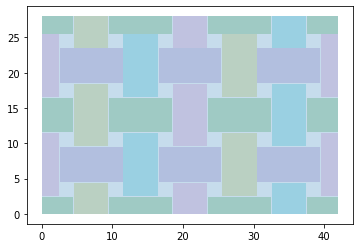

In [31]:
tile.plot(column = "label", alpha = 0.25)

In [91]:
tile.to_file("tile.geojson", driver = "GeoJSON")

## Possible tiling code
But this is hard to use and MMGIS does the needful anyway.

Won't work with updated `Weave` class... due to the extra 'buffer' polygons.

In [ ]:
def tile(w, minx = -30, miny = -30, maxx = 30, maxy = 30, rotation = 0):
    tiling_w = maxx - minx
    tiling_h = maxy - miny
    bb = unary_union(w.shapes).bounds
    width = bb[2] - bb[0]
    height = bb[3] - bb[1]
    repeats_h = math.ceil(tiling_w / width)
    repeats_v = math.ceil(tiling_h / height)
    total_w = repeats_h * width
    total_h = repeats_v * height
    origin_offset_x = (minx - (total_w - tiling_w) / 2) - bb[0]
    origin_offset_y = (miny - (total_h - tiling_h) / 2) - bb[1]
    template = []
    for s in deepcopy(w.shapes):
        template.append(translate(s, origin_offset_x, origin_offset_y))
    shapes = []
    for col in range(repeats_h):
        for row in range(repeats_v):
            for t in template:
                shapes.append(translate(deepcopy(t), w.dx * col, w.dy * row))
    labels = w.labels * (repeats_h * repeats_v)
    return geopandas.GeoDataFrame(data = {"label": labels}, geometry = geopandas.GeoSeries(shapes))

In [180]:
t = tile(w)

<AxesSubplot:>

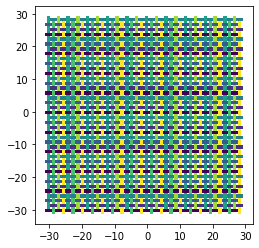

In [181]:
t.plot(column = "label")

In [178]:
t.to_file("weave.gpkg", driver = "GPKG")

In [48]:
gdf.geometry

0    POLYGON ((-1.50000 -0.50000, 1.50000 -0.50000,...
1    POLYGON ((0.50000 -0.50000, 3.50000 -0.50000, ...
2    POLYGON ((-0.50000 0.50000, 2.50000 0.50000, 2...
3    POLYGON ((-0.50000 0.50000, 2.50000 0.50000, 2...
Name: geometry, dtype: geometry

In [62]:
str(5)

'5'